# Simulate returns based on a GARCH volatility process

In [1]:
import pandas as pd
import arch.data.sp500
from arch import arch_model
import plotly.express as px

In [13]:
data  = pd.read_csv(r"C:\Users\ASUS\Desktop\Study\Data\Ứng dụng Python trong tài chính\Chapter 8 - Volatility Models\vnindex_2010_2020_daily.csv", index_col = 0, 
                   parse_dates = True)
market = data['price']
returns = 100 * market.pct_change().dropna()
returns.name = 'Returns'
returns = returns.to_frame()

In [14]:
returns

,Returns
date,
2010-01-05,2.993908
2010-01-06,0.362421
2010-01-07,-0.209557
2010-01-08,-2.332471
2010-01-11,-1.121136
...,...
2019-12-25,0.212748
2019-12-26,-0.242476
2019-12-27,0.513254


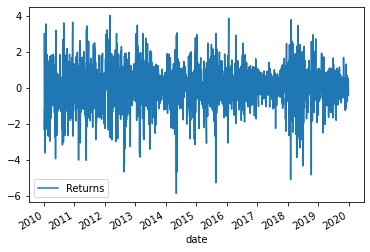

In [15]:
returns.plot();

In [16]:
am = arch_model(returns, p=1, q=1, dist='skewt')
garch_output = am.fit(disp='off')
print(garch_output.summary())

                           Constant Mean - GARCH Model Results                           
Dep. Variable:                           Returns   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                                 GARCH   Log-Likelihood:               -3487.45
Distribution:      Standardized Skew Student's t   AIC:                           6986.90
Method:                       Maximum Likelihood   BIC:                           7021.82
                                                   No. Observations:                 2491
Date:                           Mon, May 09 2022   Df Residuals:                     2490
Time:                                   18:12:45   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
------------------------------------

In [17]:
stock_garch = returns.copy()
stock_garch['cond_vol'] =  pd.DataFrame(garch_output.conditional_volatility)
garch_plot = px.line(stock_garch, title = 'GARCH vol of Daily Returns', width=1000, height=500)
garch_plot.update_layout(showlegend=False)
garch_plot.show()

In [18]:
def run_garch_model(returns):
    # using GARCH 1-1 with Skewed Student-t Distribution of returns
    am = arch_model(returns, p=1, q=1, dist='skewt')
    res = am.fit(disp='off')
    return res

In [19]:
def simulate_returns(garch_parameters, num_days_to_simulate = 1000):
    sim_mod = arch_model(None, p=1, q=1, dist="skewt")
    sim_data = sim_mod.simulate(garch_parameters, num_days_to_simulate)
    return sim_data['data']

In [20]:
def simulate_many_returns(returns, num_sims=10, num_days_to_simulate=1000):
    sim_df = pd.DataFrame(index = range(num_days_to_simulate), columns = range(num_sims))
    res = run_garch_model(returns)
    garch_parameters = res.params
    for i in range(num_sims):
        simulated_returns = simulate_returns(garch_parameters, num_days_to_simulate)
        sim_df.loc[:,i] = simulated_returns
    return sim_df  

In [21]:
sim_df = simulate_many_returns(returns, num_sims=20, num_days_to_simulate=1000)

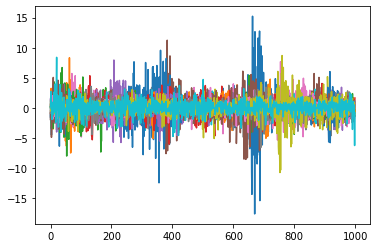

In [22]:
sim_df.plot(legend =False)

In [23]:
import plotly.figure_factory as ff

group_labels = sim_df.columns

fig = ff.create_distplot(sim_df.T.to_numpy(), group_labels, bin_size=.1)
fig.show()

In [25]:
rets_ts = (1+sim_df/100).cumprod()-1

In [26]:
fig = px.line(rets_ts)
fig.show()